In [1]:
import functools
import jax
import os
import html

from datetime import datetime
from jax import numpy as jp
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html

import shutil

from src.pods.Pods import train as train_pods
from src.hds.Hds import train as train_hds
from src.env.Pendulum import InvertedPendulum
import pickle




In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

cpu
[CpuDevice(id=0)]


In [3]:
env = InvertedPendulum(target=jp.array([1]))
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

#HTML(html.render(env.sys, [state.pipeline_state]))

In [4]:
ckpt_dir = './tmp/flax_ckpt'

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)  # Remove any existing checkpoints from the last notebook run.

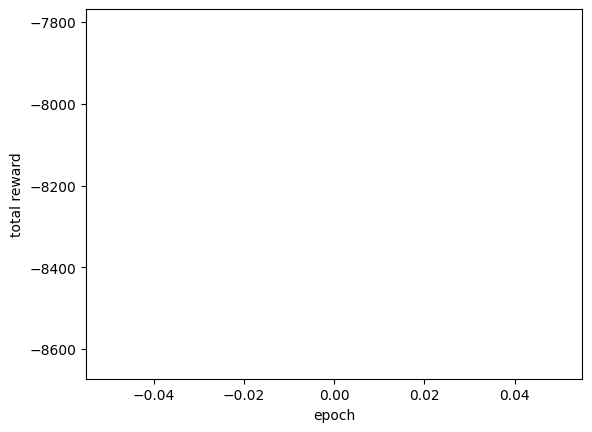

In [5]:

def progress_f(x_data,y_data,epoch,reward):
    print(reward)
    x_data.append(epoch)
    y_data.append(reward)
    clear_output(wait=True)
    plt.xlabel('epoch')
    plt.ylabel('total reward')
    plt.plot(x_data, y_data)
    plt.show()

policy = train_hds(env,trajectory_length=50 ,num_samples=50,epochs=50, inner_epochs=20, alpha_a=0.0, init_learning_rate=1e-3, init_noise=0.1, noise_decay=0.5, progress_fn=progress_f) 
#policy = train_pods(env,trajectory_length=50 ,num_samples=100,epochs=50, inner_epochs=20, alpha_a=0.0, init_learning_rate=1e-3, progress_fn=progress_f)

In [ ]:
f = open("reward.txt", "w")
g = open("actions.txt", "w")
inference_fn = policy()
rollout = []
rng = jax.random.PRNGKey(seed=0)
state = env.reset(rng=rng)
reward = []
actions = []
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  #print(state.obs)
  act = inference_fn(state.obs)
  print(act)
  reward.append(state.reward)
  state = env.step(state, act)
  #print(state.reward)
  actions.append(act)

  
print(reward, file=f)
print(actions, file=g)

[0.20602029]
[0.1573351]
[0.1249527]
[0.07535811]
[0.06530837]
[0.0716195]
[0.0986954]
[0.09392511]
[0.07941519]
[0.08463854]
[0.11131015]
[0.17947976]
[0.25045799]
[0.28571739]
[0.30185439]
[0.31493398]
[0.32974271]
[0.34027962]
[-0.10950387]
[-0.29285368]
[-0.37477956]
[-0.3489046]
[-0.14025655]
[-0.06776125]
[-0.19088496]
[-0.18884291]
[-0.15776729]
[-0.11962763]
[-0.08460872]
[-0.05532878]
[-0.12844963]
[-0.30371714]
[-0.55529193]
[-0.84529266]
[-0.90844475]
[-0.89049184]
[-0.7022806]
[-0.28617416]
[-0.00485944]
[0.0860865]
[0.19916317]
[0.25148189]
[0.2481791]
[0.2185552]
[0.19861162]
[0.18188457]
[0.17984049]
[0.17734025]
[0.20799431]
[0.22916917]
[0.2252922]
[0.1898855]
[0.13065852]
[0.08908446]
[0.06372598]
[0.04556234]
[0.04028139]
[0.02820365]
[0.01071773]
[0.00448406]
[0.00034456]
[-0.0057469]
[-0.01183572]
[-0.01974057]
[-0.02847795]
[-0.02940706]
[-0.05047913]
[-0.06917971]
[-0.0864363]
[-0.1078515]
[-0.09384755]
[-0.07045128]
[0.00148965]
[0.11514598]
[0.25414318]
[0.3223

In [ ]:
yes=html.render(env.sys.replace(), rollout)
with open("data.html", "w") as file:
    file.write(yes)